In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import nibabel as nib
from tqdm import tqdm
import os

from retina.retina import warp_image
import PIL.Image as Image
import skimage.io
import skimage.transform
import cv2

## 1- Converting the Movie (to 2 fps and 96x96 img dimension)

In [2]:
os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps/edit_videoFrames_matlab/videos')

In [3]:
! ls

segment1.avi  segment3.avi  segment5.avi  segment7.avi
segment2.avi  segment4.avi  segment6.avi  segment8.avi


In [4]:
os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')

videodir_test = '/home/soyorh/Desktop/studyforrest/Preprocessing steps/edit_videoFrames_matlab/videos'
videodir_train = '/home/soyorh/Desktop/studyforrest/Preprocessing steps/edit_videoFrames_matlab/videos'

os.makedirs('testing_videos', exist_ok=True)
os.makedirs('training_videos', exist_ok=True)

list_testvids = os.listdir(videodir_test)
list_trainvids = os.listdir(videodir_train)

In [5]:
# ###### T E S T I N G for 2s per frame

# for i in range(1, len(list_testvids)+1):
#     !ffmpeg -i /home/soyorh/Desktop/studyforrest/Preprocessing\ steps/edit_videoFrames_matlab/videos/segment{i}.avi -an -vf "scale=96:96, fps=0.5" -y testing_videos/seg_{i}_96x96.webm

In [6]:
# [swscaler @ 0x5579cf9ad560] deprecated pixel format used, make sure you did set range correctly
# [libvpx-vp9 @ 0x5579cf959e60] v1.7.0
# Output #0, webm, to 'testing_videos/seg_2_96x96.webm':
#   Metadata:
#     encoder         : Lavf57.83.100
#     Stream #0:0: Video: vp9 (libvpx-vp9), yuv420p, 96x96 [SAR 1:1 DAR 1:1], q=-1--1, 200 kb/s, 0.50 fps, 1k tbn, 0.50 tbc
#     Metadata:
#       encoder         : Lavc57.107.100 libvpx-vp9
#     Side data:
#       cpb: bitrate max/min/avg: 0/0/0 buffer size: 0 vbv_delay: -1
# frame=  441 fps= 12 q=0.0 Lsize=    2300kB time=00:14:40.00 bitrate=  21.4kbits/s speed=23.2x    
# video:2294kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.269004%

In [7]:
# ###### T R A I N I N G for 2s per frame

# for i in range(1, len(list_trainvids)+1):
#     !ffmpeg -i /home/soyorh/Desktop/studyforrest/Preprocessing\ steps/edit_videoFrames_matlab/videos/segment{i}.avi -an -vf "scale=96:96, fps=0.5" -y training_videos/seg_{i}_96x96.webm

## 2- Generate Targets 
(+ remove the last 9 frames from each run. Since shift + time_range = 9 ('Cause fmri duration == movie duration)

### # Functions

In [8]:
def read_frames(path):
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame[..., ::-1])

    return np.stack(frames)

def to_numpy_all_runs(set_t, leftOut_frames=9):
    
    '''
    set_t : training or testing.
    
    leftOut_frames: shift + time_range # 'Cause fmri duration == movie duration. 
                    Refers to the Shift and Stuck the fMRI step
    
    '''
    if set_t == 'testing':
        list_vid = os.listdir(videodir_test)

    elif set_t == 'training':
        list_vid = os.listdir(videodir_train)

    for run_nr in tqdm(range(1, len(list_vid)+1)):
        fps_run = read_frames(f'{set_t}_videos/seg_{run_nr}_96x96.webm')[:-leftOut_frames]
        np.save(f'{set_t}_videos/{set_t[:-3]}_video_run{run_nr}.npy', np.array(fps_run))

### # save_videosinruns

In [41]:
to_numpy_all_runs('training')

100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


In [42]:
to_numpy_all_runs('testing')

100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


### # check the data

In [3]:
set_t = 'testing'
os.chdir(f'/home/soyorh/Desktop/studyforrest/Preprocessing steps/{set_t}_videos/')

In [4]:
!ls

seg_1_96x96.webm  seg_7_96x96.webm	   test_video_run4.npy
seg_2_96x96.webm  seg_8_96x96.webm	   test_video_run5.npy
seg_3_96x96.webm  test_targets_warped.npy  test_video_run6.npy
seg_4_96x96.webm  test_video_run1.npy	   test_video_run7.npy
seg_5_96x96.webm  test_video_run2.npy	   test_video_run8.npy
seg_6_96x96.webm  test_video_run3.npy


In [10]:
### Their shape is the same with fMRI movie recordings!

np.load('test_video_run7.npy').shape, np.load('test_video_run8.npy').shape

((534, 96, 96, 3), (328, 96, 96, 3))

## 3- Retinawarp

In [46]:
os.chdir(f'/home/soyorh/Desktop/studyforrest/Preprocessing steps/')

In [47]:
def retinawarp(set_t, files=f'{set_t}_videos/{set_t[:-3]}_video_run*'):
    
    '''
    Steps ocurring in the function:
    
    1 - Loads in the targets one-by-one, 
    2 - concatenate then together
    3 - Warps the targets and seve them
    
    '''
    
    number_of_run_files = len(glob(files))
    
    targets_list = []
    for run_i in tqdm(range(1, number_of_run_files+1)):
            
        seen_img =  np.load(f'{set_t}_videos/{set_t[:-3]}_video_run{run_i}.npy')
        n_frames = seen_img.shape[0]
        targets_list.append(seen_img/255)

    targets = np.concatenate(targets_list).astype('float32')
    
    ## R E T I N A W A R P
    for fi in tqdm(range(targets.shape[3])): 
        img = np.transpose(targets[:, :, :, fi], [1, 2, 0])
        img = warp_image(img)
        targets[ :, :, :, fi] = np.transpose(img, [2, 0, 1])
    
    np.save(f'{set_t}_videos/{set_t[:-3]}_targets_warped.npy', np.array(targets))

In [48]:
retinawarp('testing')

100%|██████████| 3/3 [00:20<00:00,  6.95s/it]


In [49]:
retinawarp('training')

100%|██████████| 3/3 [00:19<00:00,  6.63s/it]


### # check the data

In [50]:
set_t = 'testing'
x = np.load(f'{set_t}_videos/{set_t[:-3]}_targets_warped.npy')

In [51]:
x.shape

(3527, 96, 96, 3)

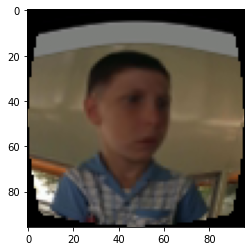

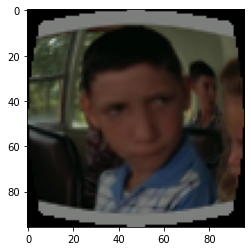

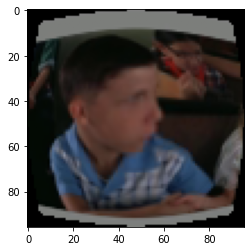

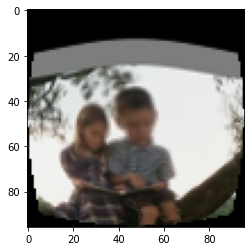

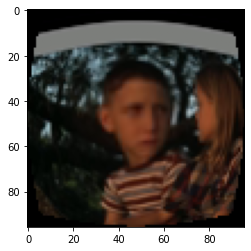

In [52]:
start = 400
until = start + 50
step = 10

os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')
os.makedirs('example_frames', exist_ok=True)

for idx in range(start, until, step):
    fig = plt.figure(frameon=False)
    plt.imshow(x[idx])
    plt.show()
    
    fig.savefig(f'example_frames/{idx}', transparent = True, bbox_inches = 'tight', pad_inches = 0)
